# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

Necessary imports and helper functions for displaying points, boxes, and masks.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [6]:
x = cv2.imread('../images/outfit.jpg')
x.shape

(880, 650, 3)

In [8]:
x = open("../images/outfit.jpg", 'rb')

In [9]:
x.shape

AttributeError: '_io.BufferedReader' object has no attribute 'shape'

In [3]:
image = cv2.imread('../images/outfit.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

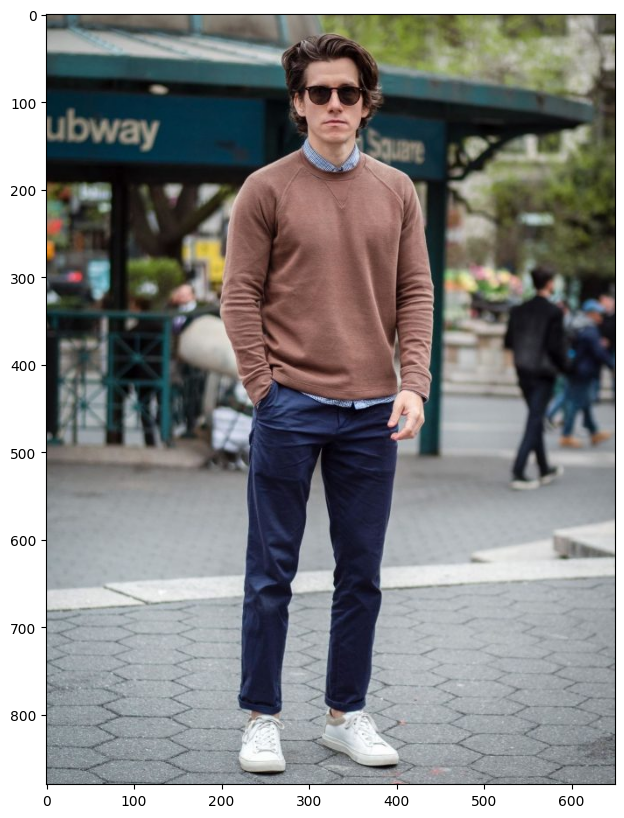

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [5]:
import sys
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "../checkpoints/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [31]:
np.array([[1,2]])

array([[1, 2]])

In [6]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [7]:
input_point = np.array([[350, 375]])
input_label = np.array([1])

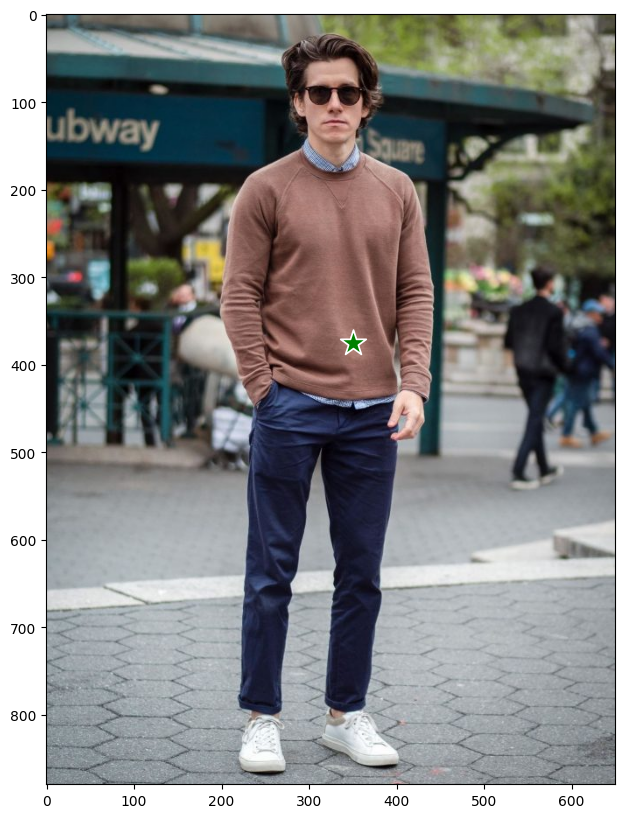

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [9]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [28]:
bestmask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [30]:
bestmask = masks[np.argmax(scores)]
bestmask.astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [ ]:
masks.shape  # (number_of_masks) x H x W

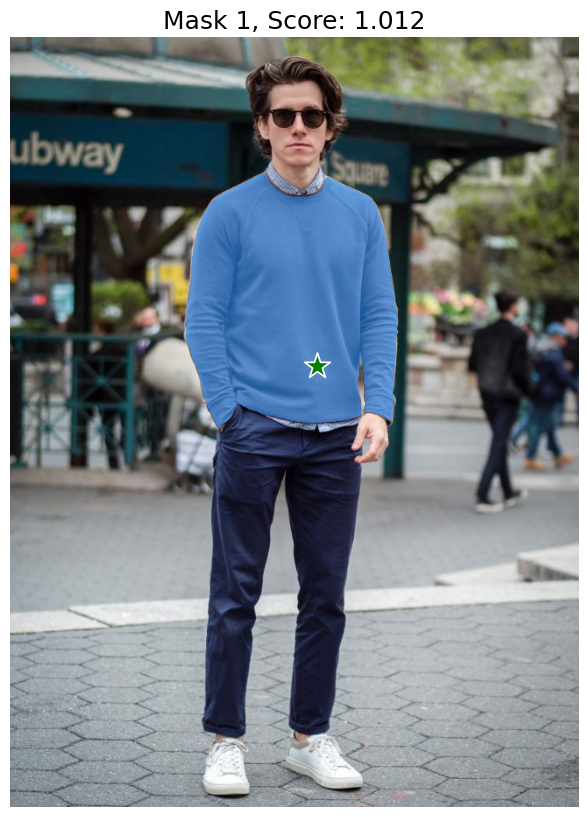

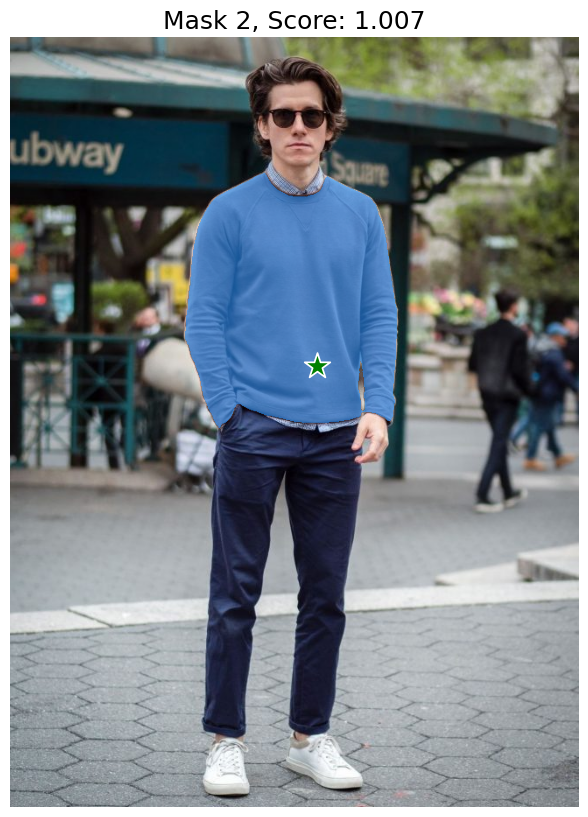

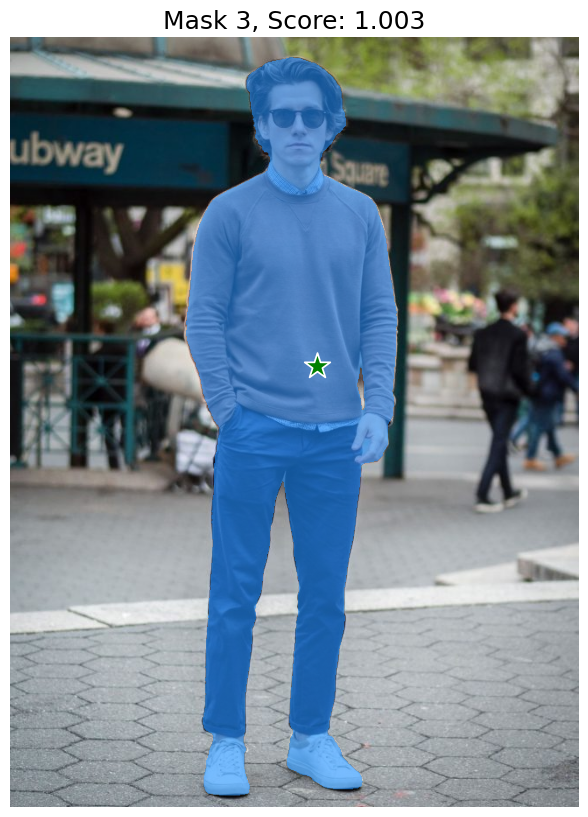

In [12]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [ ]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
masks.shape

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [ ]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [ ]:
input_box = np.array([425, 600, 700, 875])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [ ]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## Batched prompt inputs

SamPredictor can take multiple input prompts for the same image, using `predict_torch` method. This method assumes input points are already torch tensors and have already been transformed to the input frame. For example, imagine we have several box outputs from an object detector.

In [ ]:
input_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=predictor.device)

Transform the boxes to the input frame, then predict masks. `SamPredictor` stores the necessary transform as the `transform` field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

In [ ]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [ ]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

## End-to-end batched inference

If all prompts are available in advance, it is possible to run SAM directly in an end-to-end fashion. This also allows batching over images.

In [ ]:
image1 = image  # truck.jpg from above
image1_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=sam.device)

image2 = cv2.imread('images/groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
], device=sam.device)

Both images and prompts are input as PyTorch tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:
* `image`: The input image as a PyTorch tensor in CHW format.
* `original_size`: The size of the image before transforming for input to SAM, in (H, W) format.
* `point_coords`: Batched coordinates of point prompts.
* `point_labels`: Batched labels of point prompts.
* `boxes`: Batched input boxes.
* `mask_inputs`: Batched input masks.

If a prompt is not present, the key can be excluded.

In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [ ]:
batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

Run the model.

In [ ]:
batched_output = sam(batched_input, multimask_output=False)

The output is a list over results for each input image, where list elements are dictionaries with the following keys:
* `masks`: A batched torch tensor of predicted binary masks, the size of the original image.
* `iou_predictions`: The model's prediction of the quality for each mask.
* `low_res_logits`: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.

In [ ]:
batched_output[0].keys()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box.cpu().numpy(), ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box.cpu().numpy(), ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()